## <font color="Greenyellow">Trabajo de Fin Master 3: Optimizacion de hiperparametros</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Modelos base](#item3)


***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [1]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import fbeta_score
# Optimizadores
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# Modelos
import joblib

#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


***
<a id="item3"></a>
### <font color="Greenyellow">3. XGBoost (tipo boosting)</font>
[Volver al indice](#item0)

#### <font color="Greenyellow">3.1. Modelo sin optimizar</font>

1. Entrenando el modelo...
... entrenamiento completado.
    A. Precisión del modelo: 0.9996
    B. F1 Score: 0.8521
    C. AUC: 0.9401
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8000
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.91      0.80      0.85        90

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



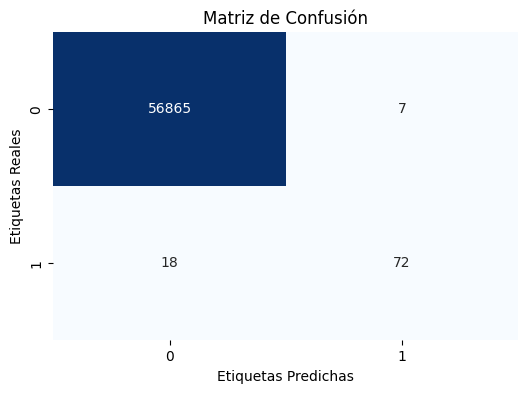


   Puntuaciones F1 de CV (k=5): [0.73202614 0.80272109 0.73202614 0.76923077 0.7972028 ]
   Promedio de F1 de CV: 0.7666


In [5]:
# 1. Instanciamos el modelo
model = xgb.XGBClassifier(n_estimators=20,
                          random_state=semilla,
                          n_jobs=-1,
                          eval_metric='logloss')
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 4. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

#### <font color="Greenyellow">3.2. Optimizacion de hiperparametros</font>

In [6]:
# Instanciamos el modelo a optimizar
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)

In [7]:
# Define el espacio de búsqueda
espacio_busqueda = {
    "n_estimators": Integer(100,  500),
    "max_depth": Integer(3, 10),
    "learning_rate": Real(0.01, 0.2, prior='log-uniform'),
    "subsample": Real(0.6, 1.0),
    "colsample_bytree": Real(0.6, 1.0),
    "gamma": Real(0, 0.5),
    "reg_alpha": Real(0, 1.0),
    "reg_lambda": Real(1.0, 3.0),
    "scale_pos_weight": Real(1.0, 3.0)
}
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=semilla)
# Búsqueda Bayesiana
opt = BayesSearchCV(
    estimator=model,
    search_spaces=espacio_busqueda,
    scoring="average_precision",
    cv=cv,
    n_iter=50,
    n_jobs=10,
    verbose=0,
    random_state=semilla
)

# Entrenamiento del optimizador
opt.fit(X_train, y_train)

# Mejor resultado
print("Mejores parámetros encontrados:")
print(opt.best_params_)
print(f"Mejor puntuación average_precision (AUC-PR): {opt.best_score_:.4f}")

Mejores parámetros encontrados:
OrderedDict([('colsample_bytree', 0.7263836582938162), ('gamma', 0.10093782039273438), ('learning_rate', 0.07051438054551648), ('max_depth', 4), ('n_estimators', 428), ('reg_alpha', 0.0036476870417830884), ('reg_lambda', 1.5030215623113654), ('scale_pos_weight', 2.9654975338746716), ('subsample', 0.6009180476396165)])
Mejor puntuación average_precision (AUC-PR): 0.8562


In [8]:
# Guardamos los mejores parametros con joblib
joblib.dump(opt.best_params_, 'data/parametros/xgb_best_params.pkl')

['data/parametros/xgb_best_params.pkl']

#### <font color="Greenyellow">3.3. Modelo optimizado</font>

In [9]:
# Cargamos los mejores parametros
best_params_xgb = ""
best_params_xgb = joblib.load('data/parametros/xgb_best_params.pkl')
best_params_xgb

OrderedDict([('colsample_bytree', 0.7263836582938162),
             ('gamma', 0.10093782039273438),
             ('learning_rate', 0.07051438054551648),
             ('max_depth', 4),
             ('n_estimators', 428),
             ('reg_alpha', 0.0036476870417830884),
             ('reg_lambda', 1.5030215623113654),
             ('scale_pos_weight', 2.9654975338746716),
             ('subsample', 0.6009180476396165)])

1. Entrenando el modelo...
... entrenamiento completado.
    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.9036
    C. AUC: 0.9837
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8333
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.99      0.83      0.90        90

    accuracy                           1.00     56962
   macro avg       0.99      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



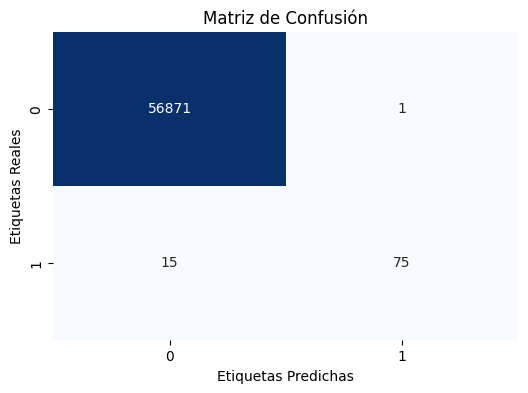


   Puntuaciones F1 de CV (k=5): [0.82894737 0.86666667 0.82432432 0.83221477 0.90789474]
   Promedio de F1 de CV: 0.8520


In [10]:
# 1. Instanciamos el modelo
model = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 4. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

In [11]:
f2_xgb = fbeta_score(y_test, model.predict(X_test), beta=2, pos_label=1)
print(f'F2 score LightGBM: {f2_xgb:.4f}')

F2 score LightGBM: 0.8601


In [12]:
# guardamos f1 y recall_minoritaria
joblib.dump(f1, 'data/metricas/f1_xgb.pkl')
joblib.dump(recall_minoritaria, 'data/metricas/recall_xgb.pkl')
joblib.dump(f2_xgb, 'data/metricas/f2_xgb.pkl')

['data/metricas/f2_xgb.pkl']

***
[Volver al indice](#item0)